In [1]:
# === EGARCH Residual Diagnostics Notebook ===
# Setup paths and import project modules

import os
import sys


notebook_dir = os.path.abspath(os.getcwd())
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
src_path = os.path.join(project_root, "src")



for path in [project_root, src_path]:
    if path not in sys.path:
        sys.path.append(path)

print(f"Project root: {project_root}")
print(f"Src path: {src_path}")

from src.config import *
from src.egarch_diagnostics import (
    egarch_residual_diagnostics,
    plot_conditional_variance,
    weekly_volatility_comparison
)


Project root: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting
Src path: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\src
[config] Project root: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting
[config] Data path: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\candles\train_sample.csv
[config] Plots directory: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\plots
[config] Logs directory: C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\logs
[config] Default EGARCH params -> p=1, o=1, q=1, dist=t


In [2]:
# === Load training data used for EGARCH model ===
import pandas as pd

train_path = os.path.join(project_root, "candles", "train_sample.csv")
df = pd.read_csv(train_path)
df["open_time"] = pd.to_datetime(df["open_time"])
df = df.sort_values("open_time").reset_index(drop=True)

print(f"✅ Loaded training data ({df.shape[0]} rows)")



✅ Loaded training data (17280 rows)


In [3]:
# === Load pre-trained EGARCH model ===
import pickle

model_path = os.path.join(project_root, "data", "egarch_model.pkl")
if not os.path.exists(model_path):
    raise FileNotFoundError(f"❌ Trained model not found: {model_path}")

with open(model_path, "rb") as f:
    res = pickle.load(f)

print(f"✅ Loaded EGARCH model from {model_path}")


✅ Loaded EGARCH model from C:\GitHubRepo\data-science\projects\ETH-volitality-fotecasting\data\egarch_model.pkl



══════════════════════════════════════════════════════════════════════
                  Extracting Standardized Residuals                   
══════════════════════════════════════════════════════════════════════

Sample size: 17267
Mean (≈ 0): 0.002473
Variance (≈ 1): 1.023408

══════════════════════════════════════════════════════════════════════
                  Ljung–Box Test for Autocorrelation                  
══════════════════════════════════════════════════════════════════════

      lb_stat  lb_pvalue
20  20.853525   0.405799

══════════════════════════════════════════════════════════════════════
           ARCH-LM Test for Conditional Heteroskedasticity            
══════════════════════════════════════════════════════════════════════

ARCH-LM statistic = 50.1504, p-value = 0.0000

══════════════════════════════════════════════════════════════════════
                    Jarque–Bera Test for Normality                    
═══════════════════════════════════════════════════

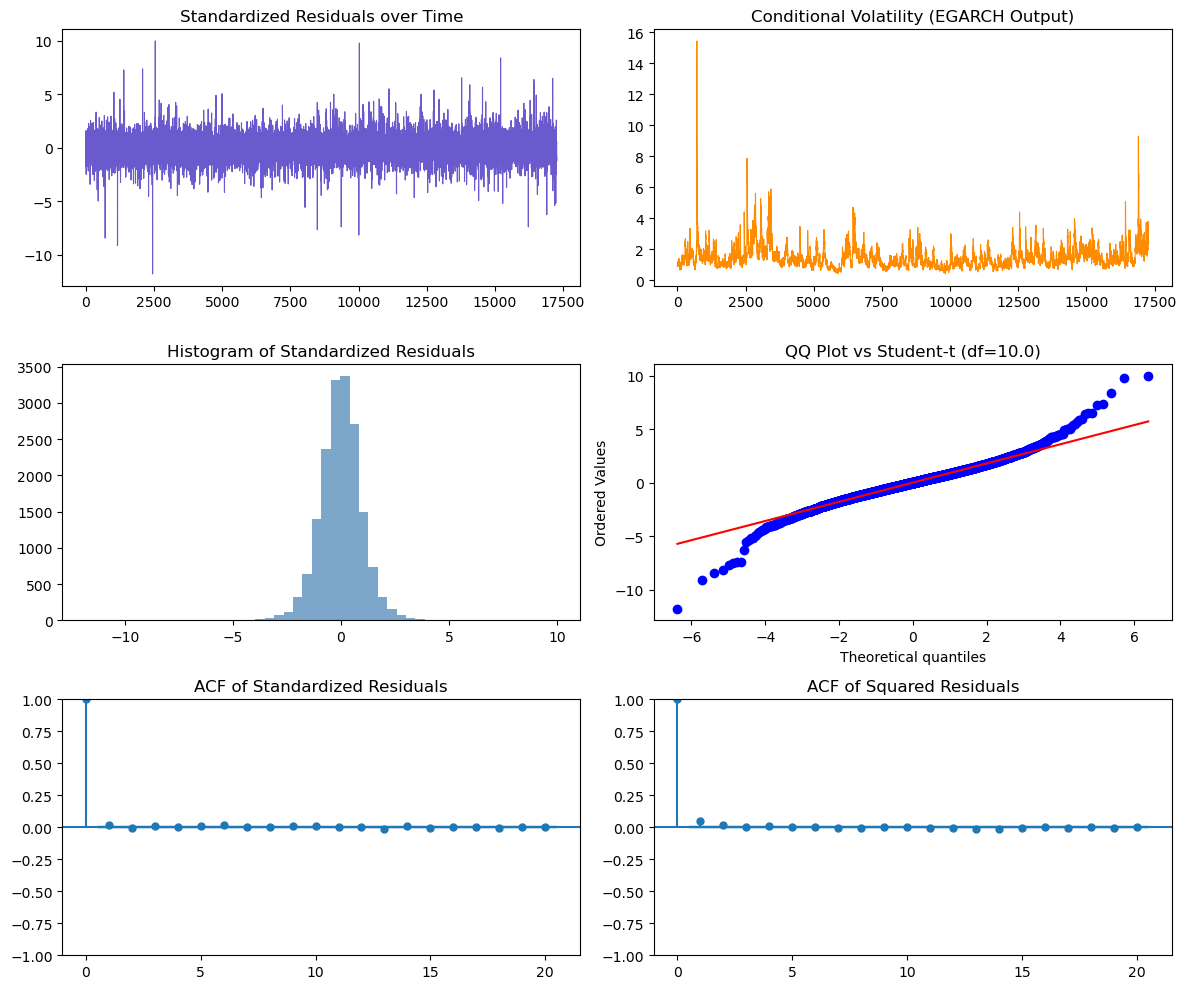


══════════════════════════════════════════════════════════════════════
                    Summary of Diagnostic Results                     
══════════════════════════════════════════════════════════════════════

Ljung_Box_p          : 0.405799
ARCH_LM_p            : 0.000000
Jarque_Bera_p        : 0.000000
Skewness             : -0.043653
Kurtosis             : 6.198200


{'Ljung_Box_p': 0.40579872176010884,
 'ARCH_LM_p': 2.50431340999267e-07,
 'Jarque_Bera_p': 0.0,
 'Skewness': -0.04365278924573747,
 'Kurtosis': 6.198199966668823}

In [4]:
# === Run residual diagnostics on the trained model ===
diagnostics = egarch_residual_diagnostics(res, lags=20, save_plots=True)
diagnostics


## Interpretation
The persistence of conditional heteroskedasticity in the EGARCH(1,1) residuals indicates that a portion of the volatility structure remains unexplained by the current specification. This residual dependence may arise from unmodeled **higher-order dynamics**, **nonlinear asymmetries**, or **microstructural effects** (e.g., volume–volatility feedback, liquidity shocks, intraday periodicities).

At this stage, the analytical trajectory bifurcates depending on the modeling objective:

1. **Statistical Purism (Model Completeness)**  
   If the goal is to achieve *variance whiteness* — a residual process that is i.i.d. with zero conditional heteroskedasticity — the natural direction is to explore higher-order or alternative volatility models:  
   $$
   \text{EGARCH}(p,q), \quad \text{GJR-GARCH}, \quad \text{APARCH}, \quad \text{or regime-switching extensions.}
   $$  
   The objective is to absorb remaining ARCH effects and minimize the Ljung–Box and ARCH–LM test statistics.

2. **Feature Extraction (Volatility as Signal)**  
   If the EGARCH output is to serve within a *meta-model* or *feature ensemble*, the residual heteroskedasticity can be considered **informational rather than pathological**.  
   The conditional variance series and standardized residuals encapsulate *volatility regimes*, *shock clustering*, and *nonlinear persistence* — features that may be exploited by higher-capacity learners (e.g., LSTMs, Transformers, or ensemble models).  
   In this context, residual variance patterns represent latent state information about market microdynamics rather than model misspecification.

In essence, whether residual heteroskedasticity is treated as **noise to be eliminated** or **structure to be learned** depends on the epistemic stance of the modeling pipeline —  
the distinction between *closing the model* and *opening the signal*.
